In [21]:
# Block 1: Setup, Imports, and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc
)

# Visual Settings
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Load Data
try:
    df = pd.read_csv("provider_features_clean.csv")
    print(f"Data Loaded: {df.shape}")
except FileNotFoundError:
    print("Error: 'provider_features_clean.csv' not found.")

# 2. Load Model & Metadata
try:
    model = joblib.load("best_model_LogisticRegression.joblib") # Or 'best_model.joblib'
    with open("features_metadata.json", "r") as f:
        meta = json.load(f)
    print("Model and Metadata Loaded successfully.")
except FileNotFoundError:
    print("Error: Model or Metadata file not found. Run Notebook 02 first.")

feature_cols = meta.get("feature_columns", df.columns.drop(["Provider", "Target"]))
target_col = meta.get("target_column", "Target")

Data Loaded: (5410, 70)
Model and Metadata Loaded successfully.


In [22]:
# Block 2: Re-create Test Set (Crucial for Valid Evaluation)

X = df[feature_cols]
y = df[target_col]

# Split exactly as in Training (Must use same random_state=42)
_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Test Set Size: {X_test.shape[0]} providers")
print("We will evaluate the model ONLY on this unseen data.")

Test Set Size: 1623 providers
We will evaluate the model ONLY on this unseen data.


Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['inp_ClmProcedureCode_6_mean' 'inp_ClmProcedureCode_6_min'
 'inp_ClmProcedureCode_6_max' 'out_ClmProcedureCode_6_mean'
 'out_ClmProcedureCode_6_min' 'out_ClmProcedureCode_6_max']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['inp_ClmProcedureCode_6_mean' 'inp_ClmProcedureCode_6_min'
 'inp_ClmProcedureCode_6_max' 'out_ClmProcedureCode_6_mean'
 'out_ClmProcedureCode_6_min' 'out_ClmProcedureCode_6_max']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


              precision    recall  f1-score   support

          No       0.97      0.90      0.93      1471
         Yes       0.41      0.71      0.52       152

    accuracy                           0.88      1623
   macro avg       0.69      0.80      0.73      1623
weighted avg       0.92      0.88      0.89      1623



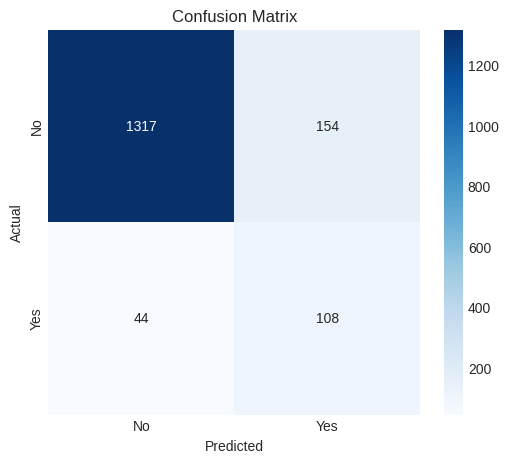

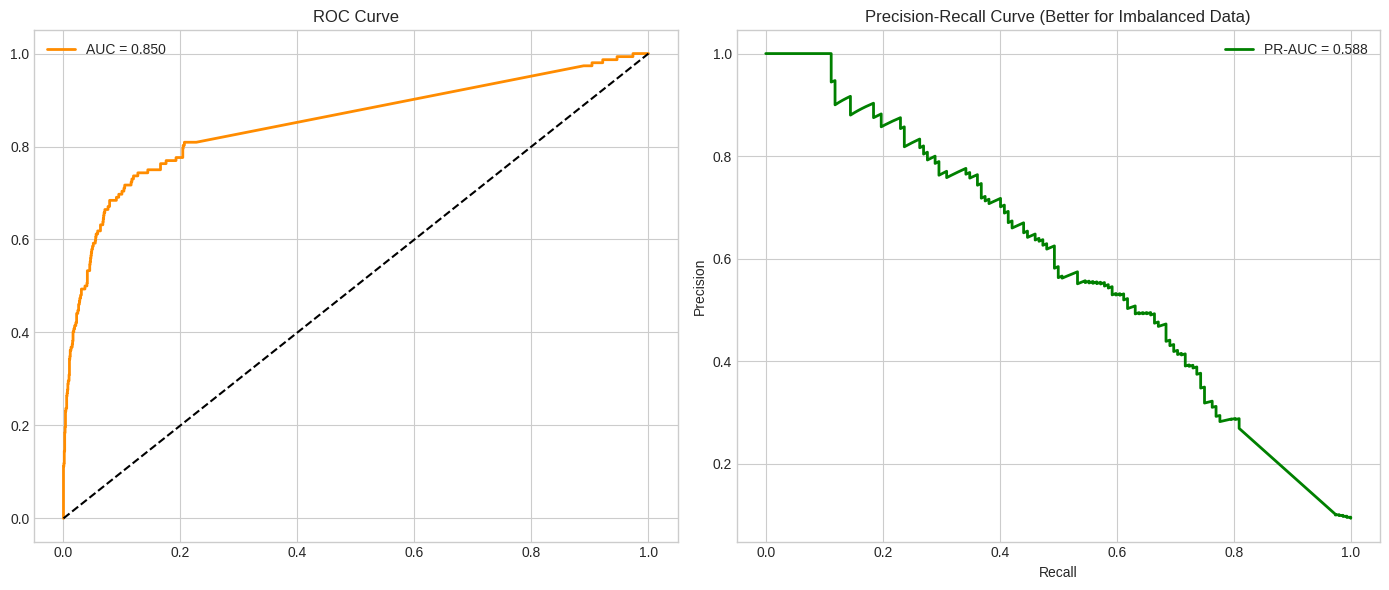

In [23]:
# Block 3: Performance Metrics & Plots

# Generate Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
y_test_bin = (y_test == "Yes").astype(int)

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. ROC and PR Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
roc_auc = roc_auc_score(y_test_bin, y_proba)
ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange', lw=2)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title("ROC Curve")
ax1.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_bin, y_proba)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}", color='green', lw=2)
ax2.set_title("Precision-Recall Curve (Better for Imbalanced Data)")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
# Block 4: Error Analysis (Case Studies)

# Combine inputs with predictions for analysis
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred
results['Prob_Fraud'] = y_proba

# Identify Errors
false_positives = results[(results['Actual'] == 'No') & (results['Predicted'] == 'Yes')]
false_negatives = results[(results['Actual'] == 'Yes') & (results['Predicted'] == 'No')]

print(f"Total False Positives: {len(false_positives)}")
print(f"Total False Negatives: {len(false_negatives)}")

# Display Top Examples
print("\n--- CASE STUDY: FALSE POSITIVES (Legit flagged as Fraud) ---")
display(false_positives.sort_values("Prob_Fraud", ascending=False).head(3))

print("\n--- CASE STUDY: FALSE NEGATIVES (Fraud missed by Model) ---")
display(false_negatives.sort_values("Prob_Fraud", ascending=True).head(3))

Total False Positives: 154
Total False Negatives: 44

--- CASE STUDY: FALSE POSITIVES (Legit flagged as Fraud) ---


,inp_InscClaimAmtReimbursed_mean,inp_InscClaimAmtReimbursed_sum,inp_InscClaimAmtReimbursed_min,inp_InscClaimAmtReimbursed_max,inp_DeductibleAmtPaid_mean,inp_DeductibleAmtPaid_sum,inp_DeductibleAmtPaid_min,inp_DeductibleAmtPaid_max,inp_ClmProcedureCode_1_mean,inp_ClmProcedureCode_1_sum,...,out_ClmProcedureCode_5_max,out_ClmProcedureCode_6_mean,out_ClmProcedureCode_6_sum,out_ClmProcedureCode_6_min,out_ClmProcedureCode_6_max,out_n_claims,out_n_bene,Actual,Predicted,Prob_Fraud
3932,11378.260870,1308500.0,0.0,57000.0,1068.0,121752.0,1068.0,1068.0,5595.237288,330119.0,...,4139.0,NaN,0.0,NaN,NaN,115.0,95.0,No,Yes,0.999988
361,9256.160714,1036690.0,0.0,57000.0,1068.0,117480.0,1068.0,1068.0,5702.866667,342172.0,...,4139.0,NaN,0.0,NaN,NaN,112.0,103.0,No,Yes,0.999978
2179,9206.896552,534000.0,0.0,47000.0,1068.0,60876.0,1068.0,1068.0,5244.333333,157330.0,...,4139.0,NaN,0.0,NaN,NaN,58.0,50.0,No,Yes,0.999964



--- CASE STUDY: FALSE NEGATIVES (Fraud missed by Model) ---


,inp_InscClaimAmtReimbursed_mean,inp_InscClaimAmtReimbursed_sum,inp_InscClaimAmtReimbursed_min,inp_InscClaimAmtReimbursed_max,inp_DeductibleAmtPaid_mean,inp_DeductibleAmtPaid_sum,inp_DeductibleAmtPaid_min,inp_DeductibleAmtPaid_max,inp_ClmProcedureCode_1_mean,inp_ClmProcedureCode_1_sum,...,out_ClmProcedureCode_5_max,out_ClmProcedureCode_6_mean,out_ClmProcedureCode_6_sum,out_ClmProcedureCode_6_min,out_ClmProcedureCode_6_max,out_n_claims,out_n_bene,Actual,Predicted,Prob_Fraud
3878,7333.333333,22000.0,5000.0,12000.0,1068.0,3204.0,1068.0,1068.0,5877.671429,0.0,...,4139.0,NaN,0.0,NaN,NaN,3.0,2.0,Yes,No,0.086929
4449,12000.000000,12000.0,12000.0,12000.0,1068.0,1068.0,1068.0,1068.0,9671.000000,9671.0,...,4139.0,NaN,0.0,NaN,NaN,1.0,1.0,Yes,No,0.132655
3561,9166.666667,55000.0,6000.0,16000.0,1068.0,5340.0,1068.0,1068.0,5609.250000,22437.0,...,4139.0,NaN,0.0,NaN,NaN,6.0,6.0,Yes,No,0.163108


/tmp/ipython-input-2832247663.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, y='Feature', x='Score', palette='coolwarm')


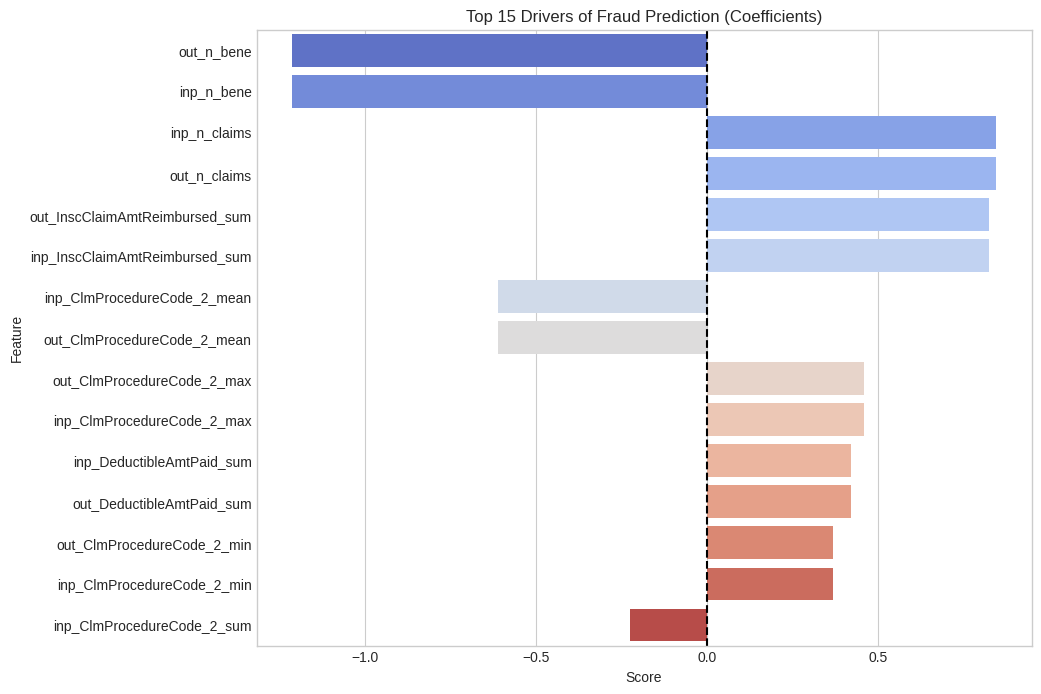


Final predictions saved to 'provider_predictions_final.csv'


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['inp_ClmProcedureCode_6_mean' 'inp_ClmProcedureCode_6_min'
 'inp_ClmProcedureCode_6_max' 'out_ClmProcedureCode_6_mean'
 'out_ClmProcedureCode_6_min' 'out_ClmProcedureCode_6_max']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [25]:
# Block 5: Explainability & Export

# 1. Feature Importance (Works for Logistic Regression or Random Forest)
if hasattr(model.named_steps['clf'], 'coef_'):
    # Logistic Regression Coefficients
    importances = model.named_steps['clf'].coef_[0]
    feat_names = model[:-1].get_feature_names_out(feature_cols)

    # Match lengths safely
    min_len = min(len(feat_names), len(importances))
    feat_df = pd.DataFrame({'Feature': feat_names[:min_len], 'Score': importances[:min_len]})
    feat_df['Abs_Score'] = feat_df['Score'].abs()
    feat_df = feat_df.sort_values('Abs_Score', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feat_df, y='Feature', x='Score', palette='coolwarm')
    plt.title("Top 15 Drivers of Fraud Prediction (Coefficients)")
    plt.axvline(0, color='k', linestyle='--')
    plt.show()

# 2. Export Predictions (as originally intended)
full_preds = model.predict(df[feature_cols])
df['Predicted_Label'] = full_preds
df[['Provider', 'Predicted_Label']].to_csv("provider_predictions_final.csv", index=False)
print("\nFinal predictions saved to 'provider_predictions_final.csv'")